<a href="https://colab.research.google.com/github/abduhsalam/Suicide-Prevention-DTI/blob/main/Suicide_Prevention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
!pip3 install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [134]:
import pandas as pd

# read csv file 1
df1 = pd.read_csv('https://raw.githubusercontent.com/hesamuel/goodbye_world/master/data/data_for_model_2.csv', sep=',')
df1 = df1.drop(['url', 'num_comments', 'author', 'title', 'selftext', 'selftext_clean', 'title_clean', 'author_clean', 'selftext_length', 'title_length'], axis=1)
df1 = df1.dropna()
df1.head()

,is_suicide,megatext_clean
0,0,sql witch understand people reply immediately ...
1,0,c irc welcome r depression check post place ta...
2,0,new killer 69 feeling really depressed lonely ...
3,0,jazz le crab literally broke cry asked go home...
4,0,depressed kid 786 kind soul want give depresse...


In [135]:
#read csv file 2
df2 = pd.read_csv('https://raw.githubusercontent.com/reetika-goel/Predict-Suicidal-Ideation-Based-on-Tweets/master/PredictSuicidalIdeationBasedonTweets/Train_suicide1.csv', sep=',')
df2.loc[df2['Suicide'] == "Potential Suicide post ", "Suicide"] = 1
df2.loc[df2['Suicide'] == "Not Suicide post", "Suicide"] = -1
df2 = df2.rename(columns = {'Tweet': 'megatext_clean', 'Suicide': 'is_suicide'}, inplace = False)
df2.is_suicide.astype('int')
df2.head()

,megatext_clean,is_suicide
0,i hate myself so much i want to KILL myself ho...,1
1,RT @DrugForumsBest: I woke up with a bag over ...,1
2,i wanna fucking kill myself,1
3,why do i destroy all my opportunities? am i go...,1
4,u - understand what the fuck im doing wrong wi...,1


In [136]:
# Combine data
df = pd.concat([df1, df2], ignore_index=True, sort=False)
df.shape

(3496, 2)

In [137]:
df = df.dropna()
df.isnull().sum()

is_suicide        0
megatext_clean    0
dtype: int64

**Text Preprocessing**

In [138]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

# Case Folding
# Convert text to lowercase
df['megatext_clean'] = df['megatext_clean'].str.lower()

# Remove Twitter megatext_clean Link and RT word
df['megatext_clean'] = df['megatext_clean'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'rt', '', regex=True)

# Remove number
df['megatext_clean'] = df['megatext_clean'].str.replace('\d+', '')

# Remove Punctuation
df['megatext_clean'] = df['megatext_clean'].str.replace('[^\w\s]','')

# Remove Whitespaces
df["megatext_clean"] = df['megatext_clean'].str.strip()

# Tokenization
df["megatext_clean"] = df["megatext_clean"].apply(nltk.word_tokenize)

# StopWords Removal
stop_words = set(stopwords.words('english'))
df["megatext_clean"] = df["megatext_clean"].apply(lambda x: [item for item in x if item not in stop_words])

# Stemming
ps = PorterStemmer()
df['megatext_clean'] = df['megatext_clean'].apply(lambda x: [ps.stem(item) for item in x])

# Lemmetizer
lemmatizer = WordNetLemmatizer()
df['megatext_clean'] = df['megatext_clean'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])

df.head()

,is_suicide,megatext_clean
0,0,"[sql, witch, understand, peopl, repli, immedi,..."
1,0,"[c, irc, welcom, r, depress, check, post, plac..."
2,0,"[new, killer, feel, realli, depress, lone, lat..."
3,0,"[jazz, le, crab, liter, broke, cri, ask, go, h..."
4,0,"[depress, kid, kind, soul, want, give, depress..."


**Suicide megatext_clean Word Cloud**

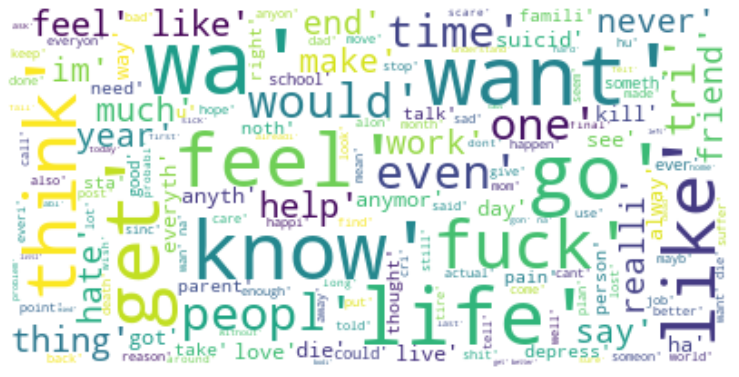

In [139]:
from os import path
from PIL import Image
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Create and generate a word cloud image:
word = df.megatext_clean[df['is_suicide']== 1].astype('string')
word.head()
wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="white").generate_from_text(' '.join(word))

# Display the generated image:
plt.figure(figsize=(13,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Depression megatext_clean Word Cloud**

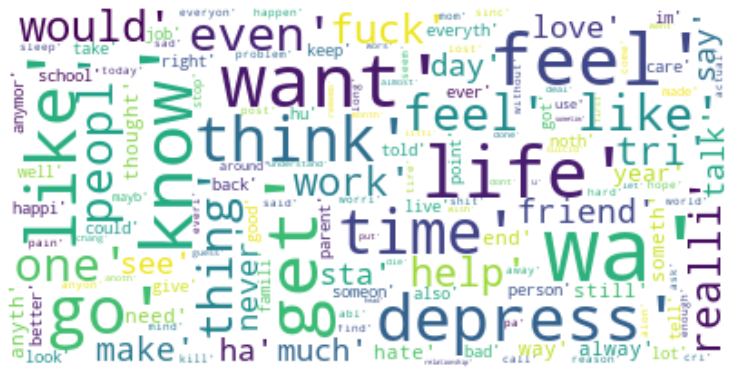

In [140]:
# Create and generate a word cloud image:
word = df.megatext_clean[df['is_suicide']== 0].astype('string')
word.head()
wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="white", ).generate_from_text(' '.join(word))

# Display the generated image:
plt.figure(figsize=(13,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Data Splitting**

In [141]:
# Set Training and Testing Data (70:30)
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test  = train_test_split(df['megatext_clean'] , df['is_suicide'], shuffle = True, test_size=0.25, random_state=1)

# Show the Training and Testing Data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2620,)
(874,)
(2620,)
(874,)


**Modelling**

In [142]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from scipy import stats
warnings.filterwarnings('ignore')

# pipeline combining transformers and estimator
ann = make_pipeline(TfidfVectorizer(lowercase=False, preprocessor=' '.join), MLPClassifier())

# grid searh to choose the best (combination of) hyperparameters
parameter_space = {
    'mlpclassifier__hidden_layer_sizes': [(10,30,10),(20,)],
    'mlpclassifier__activation': ['tanh', 'relu'],
    'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__alpha': [0.0001, 0.05],
    'mlpclassifier__learning_rate': ['constant','adaptive'],
}

gs_ann = GridSearchCV(estimator=ann, 
                      param_grid=parameter_space,
                      scoring='accuracy',
                      cv=2,
                    )

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_ann_scores = cross_val_score(gs_ann, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_ann.fit(X_train, y_train)
gs_ann_best=gs_ann.best_estimator_
gs_ann_best.fit(X_train, y_train)

y_pred_ann = gs_ann_best.predict(X_test)

acc_ann = metrics.accuracy_score(y_test, y_pred_ann)
prec_ann = metrics.precision_score(y_test, y_pred_ann)
rec_ann = metrics.recall_score(y_test, y_pred_ann)
f1_ann = metrics.f1_score(y_test, y_pred_ann)
kappa_ann = metrics.cohen_kappa_score(y_test, y_pred_ann)

print("Accuracy:", acc_ann)
print("Precision:", prec_ann)
print("Recall:", rec_ann)
print("F1 Score:", f1_ann)
print("Cohens Kappa Score:", kappa_ann)

# Visualize ROC Curve
y_pred_ann_proba = gs_ann_best.predict_proba(X_test)[::,1]
fprann, tprann, _ = metrics.roc_curve(y_test,  y_pred_ann_proba)
aucann = metrics.roc_auc_score(y_test, y_pred_ann_proba)

ValueError: ignored

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
warnings.filterwarnings('ignore')

# pipeline combining transformers and estimator
svm = make_pipeline(TfidfVectorizer(lowercase=False, preprocessor=' '.join), SVC(random_state=1, probability=True))

# grid searh to choose the best (combination of) hyperparameters
r=[0.1,0.05,1]
pg_svm = [{'svc__C':r, 'svc__kernel':['linear']}]

gs_svm = GridSearchCV(estimator= svm,                    
                    param_grid= pg_svm,
                    scoring='accuracy',
                    cv=2)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_svm_scores = cross_val_score(gs_svm, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_svm.fit(X_train, y_train)
gs_svm_best=gs_svm.best_estimator_
gs_svm_best.fit(X_train, y_train)

y_pred_svm = gs_svm_best.predict(X_test)

acc_svm = metrics.accuracy_score(y_test, y_pred_svm)
prec_svm = metrics.precision_score(y_test, y_pred_svm)
rec_svm = metrics.recall_score(y_test, y_pred_svm)
f1_svm = metrics.f1_score(y_test, y_pred_svm)
kappa_svm = metrics.cohen_kappa_score(y_test, y_pred_svm)

print("Accuracy:", acc_svm)
print("Precision:", prec_svm)
print("Recall:", rec_svm)
print("F1 Score:", f1_svm)
print("Cohens Kappa Score:", kappa_svm)

# Visualize ROC Curve
y_pred_svm_proba = gs_svm_best.predict_proba(X_test)[::,1]
fprsvm, tprsvm, _ = metrics.roc_curve(y_test,  y_pred_svm_proba)
aucsvm = metrics.roc_auc_score(y_test, y_pred_svm_proba)

In [ ]:
# Set Size and Style
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

# Comparing ROC Curve
plt.plot(fprsvm,tprsvm,label="SVM, auc="+str(aucsvm))
plt.plot(fprann,tprann,label="ANN MLP, auc="+str(aucann))

# plt.plot(fprrf,tprrf,label="Random Forest, auc="+str(aucrf))

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()